In [1]:
!pip install efficientnet-pytorch

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)
import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import time
import torch
torch.set_num_threads(36)
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from radam import RAdam
from lookahead import Lookahead

METADATA_DIR = 'data/metadata'
FACES_DIR = 'faces_saved'

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
%%time

with open('train_faces.pickle', 'rb') as handle:
    train_faces = pickle.load(handle)

with open('dev_faces.pickle', 'rb') as handle:
    dev_faces = pickle.load(handle)
    
with open('test_faces.pickle', 'rb') as handle:
    test_faces = pickle.load(handle)
    
with open('train_target.pickle', 'rb') as handle:
    train_target = pickle.load(handle)
    
with open('dev_target.pickle', 'rb') as handle:
    dev_target = pickle.load(handle)
    
with open('test_target.pickle', 'rb') as handle:
    test_target = pickle.load(handle)

len(train_faces), len(dev_faces), len(test_faces), len(train_target), len(dev_target), len(test_target)

CPU times: user 156 ms, sys: 52 ms, total: 208 ms
Wall time: 204 ms


(1063586, 10792, 10803, 1063586, 10792, 10803)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, faces_paths, faces_labels, datatype='train', transform=None):
        self.faces_paths = faces_paths
        self.datatype = datatype
        assert self.datatype in ['train', 'dev', 'test', 'inference']
        self.labels = faces_labels
        self.transform = transform

    def __len__(self):
        return len(self.faces_paths)

    def __getitem__(self, idx):
        img_name = self.faces_paths[idx]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.transpose(img, (2, 0, 1)) / 255
        if self.transform:
            img = self.transform(image=img)['image']

        if self.datatype != 'inference':
            label = self.labels[idx]
            return img, label
        else:
            return img

In [5]:
batch_size = 64
num_workers = 8

In [6]:
dataset_train = CustomDataset(faces_paths=train_faces, faces_labels=train_target, datatype='train')
dataset_dev = CustomDataset(faces_paths=dev_faces, faces_labels=dev_target, datatype='dev')
dataset_test = CustomDataset(faces_paths=test_faces, faces_labels=test_target, datatype='test')

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dev_loader = DataLoader(dataset_dev, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

torch.Size([64, 3, 224, 224])
tensor(1)


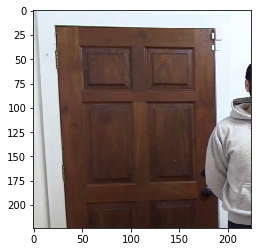

In [7]:
for X, y in train_loader:
    print(X.size())
    print(y[0])
    plt.imshow(np.transpose(X[0, :, :, :], (1, 2, 0)))
    break

# Model training

In [8]:
def seed_everything(seed=13):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def timedelta(seconds):
    return str(datetime.timedelta(seconds=seconds)).split('.')[0]

def current_time():
    return '-'.join('_'.join((datetime.datetime.now() + datetime.timedelta(hours=3)).strftime('%Y-%m-%d %H:%M:%S').split()).split(':'))

def train_model(model, dataset_train, dataset_dev, train_loader, dev_loader,
                n_epochs, criterion, optimizer, exp_name, patience=10, seed=13):
    
    start_time = time.time()

    best_val_loss = 1e9
    best_val_score = 0
    best_epoch = 0
    best_state = None
    
    curr_patience = 0
    stop = False

    seed_everything(seed)
    
    train_loss_arr = []
    val_loss_arr = []
    train_score_arr = []
    val_score_arr = []
    
    print('Starting training.')

    for epoch in range(1, n_epochs + 1):
        start_time_epoch = time.time()
        model.train()
        
        print()
        print('Epoch #{}'.format(epoch))

        train_loss_epoch = []
        
        y_true = np.zeros(len(dataset_train))
        y_pred = np.zeros(len(dataset_train))
        
        for i, (data, target) in enumerate(tqdm(train_loader, desc='train')):
            data, target = data.to(device=device).float(), target.to(device=device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            train_loss_epoch.append(loss.item())

            y_true[i * batch_size:(i+1) * batch_size] = target.data.cpu().numpy()
            y_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()
            
#             print(roc_auc_score(y_true, y_pred))

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss_epoch)
        train_loss_arr.append(train_loss)
        train_score = roc_auc_score(y_true, y_pred)
        train_score_arr.append(train_score)

        model.eval()
        val_loss_epoch = []
        y_true = np.zeros(len(dataset_dev))
        y_pred = np.zeros(len(dataset_dev))

        with torch.no_grad():
            for i, (data, target) in enumerate(tqdm(dev_loader, desc='val')):
                data, target = data.to(device=device).float(), target.to(device=device)
                output = model(data)
                loss = criterion(output, target)
                val_loss_epoch.append(loss.item()) 
                
                y_true[i * batch_size:(i+1) * batch_size] = target.data.cpu().numpy()
                y_pred[i * batch_size:(i+1) * batch_size] = output[:, 1].detach().cpu().numpy()
#                 print(roc_auc_score(y_true, y_pred))

        val_loss = np.mean(val_loss_epoch)
        val_loss_arr.append(val_loss)
        val_score = roc_auc_score(y_true, y_pred)
        val_score_arr.append(val_score)
        
        if epoch == 1:
            print('Train loss: {:.4f}, val loss: {:.4f}, train score: {:.4f}, val score: {:.4f}'.format(
                train_loss, val_loss, train_score, val_score
            ))
        else:
            print('Train loss: {:.4f} ({:+.4f}), val loss: {:.4f} ({:+.4f}), train score: {:.4f} ({:+.4f}), val score: {:.4f} ({:+.4f})'.format(
                train_loss, train_loss - train_loss_arr[-2], val_loss, val_loss - val_loss_arr[-2],
                train_score, train_score - train_score_arr[-2], val_score, val_score - val_score_arr[-2]
            ))
        
        print('Total time passed: {} | epoch: {}'.format(
            timedelta(time.time() - start_time),
            timedelta(time.time() - start_time_epoch)
        ))

        if val_score > best_val_score:
            best_val_loss = val_loss
            best_val_score = val_score
            best_epoch = epoch
            curr_patience = 0
            best_state = model.state_dict()
            score_str = '{:.6f}'.format(best_val_score).split('.')[1]
            time_curr = current_time()
            torch.save(best_state, 'models_checkpoints/{}_{}_{}_ep{}.pt'.format(time_curr, exp_name, score_str, best_epoch))
            print('Current patience: {} (SCORE IMPROVED)'.format(curr_patience))
        else:
            curr_patience += 1
            print('Current patience: {}'.format(curr_patience))
            if curr_patience > patience:
                stop = True
        
        if stop:
            print()
            print('Stopping training.')
            break

    print()
    print('Final results:')
    print('Best epoch: {}, val loss: {:.4f}, val score: {:.4f}'.format(best_epoch, best_val_loss, best_val_score))
    print('Total time passed: {}'.format(timedelta(time.time() - start_time)))
    return best_state, train_loss_arr, val_loss_arr, train_score_arr, val_score_arr

def draw_loss(train_loss_arr, val_loss_arr, name):
    plt.figure(figsize=(11.7, 8.3))
    plt.title('BCE')
    plt.plot(range(1, len(train_loss_arr) + 1), train_loss_arr, label='train')
    plt.plot(range(1, len(val_loss_arr) + 1), val_loss_arr, label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.savefig(os.path.join('plots_loss', name + '.png'))

def draw_score(train_score_arr, val_score_arr, name):
    plt.figure(figsize=(11.7, 8.3))
    plt.title('AUC-ROC')
    plt.plot(range(1, len(train_score_arr) + 1), train_score_arr, label='train')
    plt.plot(range(1, len(val_score_arr) + 1), val_score_arr, label='validation')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.legend(loc='best')
    plt.savefig(os.path.join('plots_scores', name + '.png'))

In [ ]:
EXP_NAME = 'efficientnet-b4-radam-lookahead-baseline'

model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=2)
model.to(device=device)

criterion = nn.CrossEntropyLoss()
base_opt = RAdam(model.parameters(), lr=1e-3)
optimizer = Lookahead(base_opt)

best_state, train_loss_arr, val_loss_arr, train_score_arr, val_score_arr = train_model(
    model, dataset_train, dataset_dev, train_loader, dev_loader,
    n_epochs=10,
    criterion=criterion,
    optimizer=optimizer,
    exp_name=EXP_NAME,
    patience=5,
    seed=13
)

name = EXP_NAME
draw_loss(train_loss_arr, val_loss_arr, name)
draw_score(train_score_arr, val_score_arr, name)

Loaded pretrained weights for efficientnet-b4


train:   0%|          | 0/16619 [00:00<?, ?it/s]

Starting training.

Epoch #1


train:  33%|███▎      | 5463/16619 [1:12:11<2:27:19,  1.26it/s]